# Árboles de decisión

En este notebook tomaremos como referencia el material de Aurélien Géron  que explica como entrenar, validar y realizar predicciones con árboles de decisión tomando como base el dataset de clasificación de flores iris con la librería **Scikit-learn** 

¿Qué son los Árboles de Decisión?

Son representaciones gráficas de posibles soluciones a una decisión basadas en ciertas condiciones. Es uno de los algoritmos de aprendizaje supervisado más utilizados en machine learning y pueden realizar tareas de clasificación o regresión. La comprensión de su funcionamiento suele ser simple y a la vez muy potente.

Principales características de los árboles de decision:
* Clasifica mediante el valor de los atributos
* Es una técnica de clasificación muy extendida
* También pueden utilizarse en técnicas de regresión como herramienta de predicción numérica para estimar valores reales (por ejemplo: ventas al mes, coste de compra de un vehículo...)

## 1. Importación de paquetes y dataset

In [1]:
from sklearn.datasets import load_iris  
from sklearn.tree import DecisionTreeClassifier

In [2]:
iris = load_iris(as_frame=True) #iris es un objeto de tipo diccionario (Bunch), propio de sklearn, lo convertimos a DataFrame

## 2. División del dataset

In [3]:
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

## 3. Creación del modelo de Árbol de decisión

In [4]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

## 4. Entrenamiento

In [5]:
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

## 5. Visualización del árbol de decisión

Podemos visualizar el árbol de decisiones utilizando el método export_graphiz() para exportar un archivo de representación gráfica y luego transformarlo a png:

In [6]:
from sklearn.tree import export_graphviz

In [7]:
export_graphviz(tree_clf, 
                out_file='iris_tree.dot',
                feature_names=["petal length (cm)", "petal width (cm)"],
                class_names=iris.target_names,
                rounded=True,
                filled=True)

Convertimos el archivo gráfico en un archivo .png:

In [8]:
! dot -Tpng iris_tree.dot -o iris_tree.png

Y este es el resultado:

![Resultado](iris_tree.png)

## 6. Hacer predicciones

Para clasificar un nuevo punto de datos, comenzamos en el nodo raíz del gráfico (en la parte superior) y respondemos las preguntas binarias hasta que llegamos a una hoja final. Esa última hoja representa la clase a la cuál se corresponde.
Una de las cualidades de los árboles de decisión es que requieren muy poca preparación de datos. De hecho, no requieren escalado o normalizado de las características.
Un nodo de árbol tiene los siguientes atributos:

* samples (muestras): cuenta a cuántas instancias de entrenamiento se aplica.
* value (valor): nos dice a cuántas instancias de cada clase se aplica el nodo.
* gini: mide la impureza de los nodos (nodo puro == 0). Un nodo es puro si todas las instancias de entrenamiento a las que se aplica pertenecen a la misma clase.

La siguiente ecuación muestra cómo el algoritmo de entrenamiento calcula el índice o puntuación Gini del i-ésimo nodo:

$$G_i=1-\sum_{k=1}^n{p_{i,k}}^2$$

Donde $p_{i,k}$ es la proporción o ratio de instancias de clase $k$ entre las instancias de entrenamiento en ese nodo en particular. En nuestro caso: $k \in \{1,2,3\}$.

La siguiente figura muestra los límites de decisión de este árbol. La línea vertical gruesa representa el límite de decisión del nodo raíz(profundidad 0).Como el área de la izquierda es pura ya no puede dividirse más. Sin embargo, como la derecha no lo es se vuelve a dividir. Además como max_depth=2 el árbol de decisión se detiene ahí.

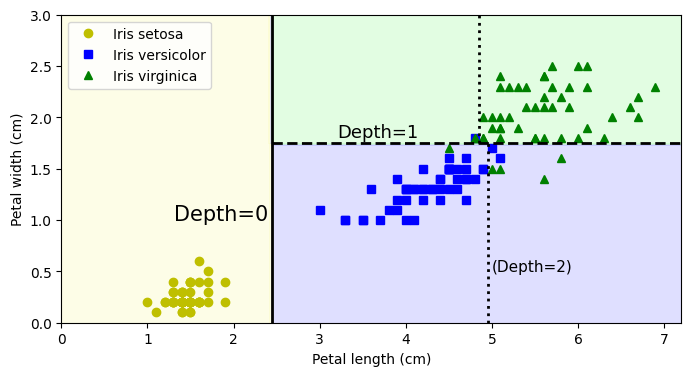

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies and saves Figure 6–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

`Scikit-learn` usa el algoritmo CART, que produce solo árboles binarios. Los nodos que no son hojas solo tienen dos hijos. Sin embargo, otros algoritmos como ID3 pueden producir árboles de decisión con nodos que tienen más de 2 hijos.

En general, los árboles de decisión son intuitivos y sus predicciones son fácilmente interpretables. Estos tipos de modelos se denominan modelos de **caja blanca**. Por contra, los RandomForest y las redes neuronales generalmente se consideran modelos de caja negra (es difícil explicar en términos sencillos por qué han hecho unas determinadas predicciones).

##  7. Estimando las probabilidades de pertenencia a cada clase

Un árbol de decisión también puede estimar la probabilidad de que cierta instancia pertenezca a cierta clase. Simplemente devuelve el ratio o proporción de esa clase sobre la suma de todas las instancias en la hoja.

Podemos comprobarlo con el método `predict_proba` de scikit-learn:

En este ejemplo, si indicamos que la longitud del pétalo es 5 y el ancho es 1.5, la probabilidad de ser de clase 0 será 0 (0/54), de clase 1 el 90.7% (49/54) y de clase 2 el 9.2% (5/54)

In [10]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [11]:
tree_clf.predict([[5, 1.5]])

array([1])


Nota: obtendremos la misma probabilidad siempre que estemos en cualquier otra parte del rectángulo derecho inferior. No importa si nuestro nuevo punto de datos se acerca a los márgenes de decisión (decision boundaries). [Por ejemplo, obtendríamos lo mismo si los pétalos midiesen 6 cm de largo por 1.5 de ancho]

## 8. El algoritmo de entrenamiento CART

Scikit-Learn utiliza el algoritmo CART (Classification and Regression Trees) para entrenar árboles de decisión.

CART genera árboles de decisiones binarios que dividen el espacio de características en regiones homogéneas, es decir, particiones en las que las instancias dentro de cada región son lo más similares posible. En Clasificación utiliza Gini o entropía y en Regresión la varianza o el error cuadrático medio como criterios par elegir la mejor división.

Una vez que el algoritmo CART divide con éxito los datos de entrenamiento inicial en dos subconjuntos, hace lo mismo con ambos subconjuntos. Deja de repetir una vez que alcanza la profundidad máxima permitida del árbol (el hiperparámetro `max_depth`), o si no puede encontrar una división que reduzca la impureza.

Una vez que ya no se puede mejorar la homogeneidad de los nodos (es decir, los nodos son "puros" o los datos restantes no pueden dividirse significativamente), el algoritmo crea nodos terminales o hojas. En las hojas:

- Clasificación: El nodo asigna la clase más frecuente de los ejemplos en ese nodo.

- Regresión: El nodo asigna el valor promedio de los ejemplos en ese nodo.

Otros hiperparámetros que controlan la detención incluyen: `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_leaf_nodes`.

El algoritmo CART es "avaricioso" en el sentido de que no le importa si su división actual conducirá a una hoja posterior óptima. Sólo le importa encontrar la mejor división posible en la hoja actual. En ese sentido, no necesariamente termina siendo una solución óptima.

## 9. Índice GINI

El índice Gini o impureza Gini es el nombre de la función de coste utilizada para evaluar las divisiones en el conjunto de datos. 

Es una medida de qué tan mixto o impuro es un conjunto de datos. La impureza de Gini varía entre 0 y 1, donde 0 representa un conjunto de datos puro y 1 representa un conjunto de datos completamente impuro.

Por defecto, DecissionTreeClassifier utiliza la medida Gini pero puede seleccionarse otra medida: la entropía. De todas formas, la mayoría de las veces parece que no hay mucha diferencia ya que nos llevan a árboles similares. Para más detalles ver el siguiente <a href="https://sebastianraschka.com/faq/docs/decision-tree-binary.html">análisis </a>.

## 10. Hiperparámetros de regularización

**Los árboles de decisión hacen muy pocas suposiciones sobre los datos de entrenamiento**. Si no se restringe, un árbol de decisión se adaptará para ajustarse perfectamente a los datos de entrenamiento, lo que naturalmente conduce al sobreajuste (overfitting).

Este modelo a menudo se denomina "modelo no paramétrico" porque la cantidad de parámetros no se determina antes del entrenamiento, así que la estructura del modelo es libre para ajustarse mucho a los datos.[Lo contrario a uno paramétrico como el lineal que tiene un número determinado de parámetros, su grado de libertad limitado y que reduce el riesgo de sobreajuste a riesgo del subajuste]

Para evitar entonces el sobreajuste, vamos a restringir la libertad del árbol de decisión durante el entrenamiento. Vamos a Regularizar. 

Al menos podemos restringir la profundidad máxima del árbol de decisión (max_depth), entre otros hiperparámetros de regularización:

* min_samples_split: el número mínimo de muestras que debe tener un nodo antes de poder dividirse.
* min_samples_leaf: El número mínimo de muestras que debe tener una hoja para crearse.
* min_weight_fraction_leaf: mean_samples_leaf expresado como una fracción del número total de instancias ponderadas.
* max_leaf_nodes: el número máximo de nodos hoja.
* max_features: el número máximo de características que se evalúan para dividir en cada nodo.

Se muestran dos árboles de decisión entrenados en el mismo conjunto de datos, el de la izquierda representa un árbol de decisión entrenado sin restricciones y el de la derecha se regulariza mediante el hiperparámetro min_samples_leaf, el de la izquierda parece sobreajustado

In [12]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

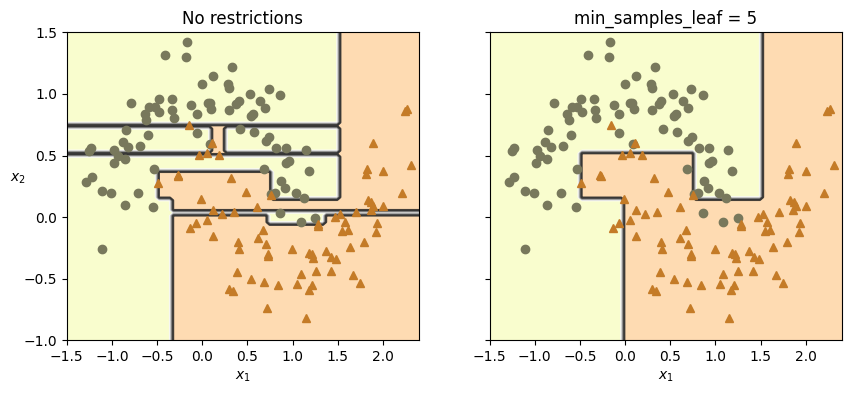

In [13]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")

plt.show()

Podemos evaluarlos en un conjunto de pruebas y el de la derecha tiene mayor exactitud

In [14]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [15]:
tree_clf2.score(X_moons_test, y_moons_test)


0.92

## 11. Ejemplo de Arbol de Decisión para Regresión

Los árboles de decisión también son capaces de realizar tareas de regresión.

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # una sola característica de entrada aleatoria
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1) #datos cuadráticos con ruido

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42) #profundidad 2
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [17]:
export_graphviz(
    tree_reg,
    out_file=("regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)

In [18]:
! dot -Tpng regression_tree.dot -o regression_tree.png

![Resultado](regression_tree.png)

Entrenamos un segundo árbol pero con profundidad 3

In [19]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

Vemos la comparativa de predicciones en las siguientes gráficas. El algoritmo CART ahora en vez de intentar dividir el conjunto de entrenamiento de forma que minimice la impureza, intenta dividirlo de manera que mimimice el Error Cuadrático Medio.

Mostramos la función de coste que el algoritmo intenta minimizar: 

$$J(k,t_k)=\frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right} \\ MSE=\frac{1}{m}\sum_{i=1}^{m}(\hat{y}_{i}-y_{i})^{2}$$

También en regresión este tipo de árbol es propenso al sobreajuste. Aquí se muestran las predicciones de un árbol sin regularizar y otro regularizado. Simplemente configurando un hiperparámetro el resultado es un modelo mucho más razonable.

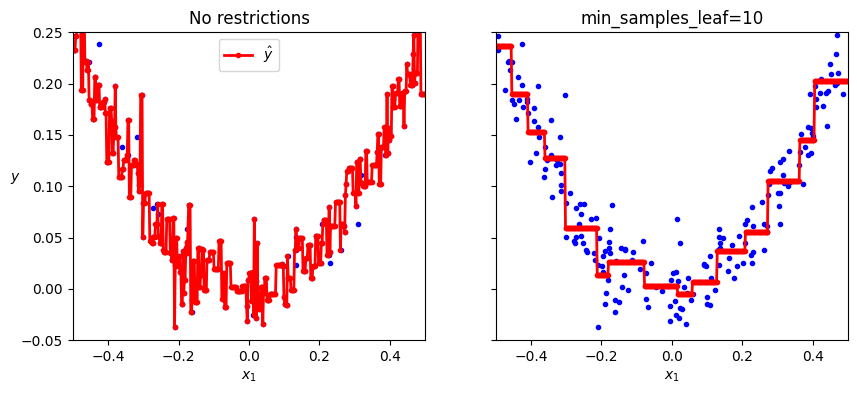

In [20]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

## Inestabilidad

Los árboles de decisión son sensibles a pequeñas variaciones en los datos de entrenamiento. De hecho, debido a que scikit-learn usa optimización estocástica, es posible que se obtengan diferentes modelos para el mismo conjunto de datos de entrenamiento.

Random Forests puede resolver este problema haciendo la media de las predicciones de muchos árboles de decisión. 
